<a href="https://colab.research.google.com/github/Farii01/Internship_PINN_work/blob/Main2/PINN2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install git+https://gricad-gitlab.univ-grenoble-alpes.fr/claveaur/pygeotools.git


  Cloning https://gricad-gitlab.univ-grenoble-alpes.fr/claveaur/pygeotools.git to /tmp/pip-req-build-x6g0_os8
  Running command git clone --filter=blob:none --quiet https://gricad-gitlab.univ-grenoble-alpes.fr/claveaur/pygeotools.git /tmp/pip-req-build-x6g0_os8
  Resolved https://gricad-gitlab.univ-grenoble-alpes.fr/claveaur/pygeotools.git to commit 87d5eab82dbae0c55a8d93113cd4ac6db38a0bf0
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pygeodyntools: filename=pygeodyntools-1.0.0-py3-none-any.whl size=42079 sha256=e1a50e0eb819856b45bfe9e6c43a5b0ac741af5d429f95892492a95eb8d7cb65
  Stored in directory: /tmp/pip-ephem-wheel-cache-oqs3l8xj/wheels/1b/45/bc/6152dd0450e643622873d26d0dbddc8621a83fc42f96b00807
Successfully built pygeodyntools
  Attempting uninstall: pygeodyntools
    Found existing installation: pygeodyntools 1.1.3
    Uninstalling pygeodyntools-1.1.3:
      Successfully u

In [2]:
import pygeotools
import torch
import torch.nn as nn
import numpy as np

In [3]:

model_path = "/content/COVOBS-x2_400reals.hdf5"

pygeo = pygeotools.pygeotools()
model_name=  "COVOBS-x2_400reals.hdf5"
pygeo.loadModel(
    modelName="COVOBS-x2_400reals.hdf5",
    modelType="covobs_hdf5",
    modelPath=model_path
)

pygeo.isLoaded("COVOBS-x2_400reals.hdf5")  # Should return True


pygeotools was initialized with `verbose=True`.


True


*   **2 Epochs**
*   **2015 data**




# **Familiarizing with pygeo**

In [4]:
help(pygeo.addMeasure)

Help on method addMeasure in module pygeotools.pygeotools:

addMeasure(modelName: str, measureName: str, context={}) -> numpy.ndarray method of pygeotools.pygeotools.pygeotools instance
    # Adding a measure with a specific context



In [5]:
help(pygeo.getQuantities) # What the function expects, What it returns, What we can do with it


Help on method getQuantities in module pygeotools.pygeotools:

getQuantities(modelName: str) -> set method of pygeotools.pygeotools.pygeotools instance
    # Retrieving the available quantities of a model



In [6]:
pygeo[model_name].keys() # what is inside models


dict_keys(['type', 'path', 'quantities', 'measures'])

In [7]:
pygeo[model_name]['quantities'].keys()# inside quantities in models

dict_keys(['dgnm', 'dq10', 'gnm', 'q10', 'times'])

In [8]:
pygeo.getQuantities(model_name)


dict_keys(['dgnm', 'dq10', 'gnm', 'q10', 'times'])

In [9]:
# i was seeing the range in time
info  = pygeo.getQuantity(model_name, "times")
print(f"Model covers from {info .min()} to {info.max()}")


Model covers from 1840.0 to 2022.0


In [10]:
times = pygeo.getQuantity(model_name, "times")
print(times[0:1])

[1840.]


## **Code starts here**

In [9]:
!pip3 install pygeodyntools --upgrade
!pip3 install pygeodyntools --upgrade


In [4]:
pygeo.setGrid(gridName="1deg")

# Extract theta and phi grid from pygeo (in radians)
_, (theta_vals, phi_vals) = pygeo.getCurrentGrid()# extracting theta and phi

print(f"Grid size: theta ({len(theta_vals)}), phi ({len(phi_vals)})")

# Convert to degrees

theta_deg = np.degrees(theta_vals)
phi_deg = np.degrees(phi_vals)

print(f"Theta (colatitude) ranges from {theta_deg.min():.2f}° to {theta_deg.max():.2f}°")
print(f"Phi (longitude) ranges from {phi_deg.min():.2f}° to {phi_deg.max():.2f}°")


Grid size: theta (180), phi (360)
Theta (colatitude) ranges from 0.00° to 180.00°
Phi (longitude) ranges from 0.00° to 360.00°


In [5]:


context = {
    "r": pygeo.constants["rCore"],  # not rEarth
    "lmax": 14
}
'''
MR and SV are in known. We will predict the predict the unknown — the flow field 𝑈= (U_theta, U_phi)

'''
year = 2020
pygeo.setGrid(gridName="1deg")


pygeo.addMeasure(modelName=model_name, measureName="MF", context= context) # theta phy br
pygeo.addMeasure(modelName=model_name, measureName="SV", context=context) # the phi and the change in br

MF = pygeo.getMeasure(model_name, "MF", context=context)
SV = pygeo.getMeasure(model_name, "SV", context=context)


# fetching phi theta in 1 degree grid of pygeo
theta_vals_rad, phi_vals_rad = pygeo.getCurrentGrid()[1]

# I used 20 values from theta (e.g., index 50 to 70)
theta_indices = np.where((theta_vals_rad >= np.radians(50)) & (theta_vals_rad <= np.radians(70)))[0]
phi_indices = np.arange(len(phi_vals_rad))  # all φ

# Use these indices to manually slice the data after full measure is computed
MF_full = pygeo.getMeasure(model_name, "MF", context=context)
SV_full = pygeo.getMeasure(model_name, "SV", context=context)

mf_grid_full = pygeo.selectFromMeasure(
    modelName=model_name,
    measure=MF_full,
    options={
        "time": year,
        "component": 0
    }
)

sv_grid_full = pygeo.selectFromMeasure(
    modelName=model_name,
    measure=SV_full,
    options={
        "time": year,
        "component": 0
    }
)

# Now slice manually to avoid pygeo collapsing dimensions
mf_grid = mf_grid_full[theta_indices][:, phi_indices]
sv_grid = sv_grid_full[theta_indices][:, phi_indices]
print("mf_grid shape:", mf_grid.shape)
print("sv_grid shape:", sv_grid.shape)




14
mf_grid shape: (20, 360)
sv_grid shape: (20, 360)


mf_grid shape: (20, 360)
sv_grid shape: (20, 360)

20 values of theta (colatitude)

360 values of phi (longitude)

the number of grid points 20 × 360 = 7200

In [6]:
# Prepare meshgrid from sliced theta and phi
theta_vals = theta_vals_rad[theta_indices]
phi_vals   = phi_vals_rad[phi_indices]

theta_grid, phi_grid = np.meshgrid(theta_vals, phi_vals, indexing="ij") # 2D for matching mf grid

# Flatten and convert to PyTorch tensors for all
theta = torch.tensor(theta_grid.flatten()[:, None], dtype=torch.float32, requires_grad=True)
phi   = torch.tensor(phi_grid.flatten()[:, None], dtype=torch.float32, requires_grad=True)

Br     = torch.tensor(mf_grid.flatten()[:, None], dtype=torch.float32, requires_grad=True)
dBr_dt = torch.tensor(sv_grid.flatten()[:, None], dtype=torch.float32, requires_grad=True)

print(f"theta: {theta.shape}, phi: {phi.shape}, Br: {Br.shape}, dBr_dt: {dBr_dt.shape}")

inputs = torch.cat([theta, phi], dim=1)  # Shape: [7200, 2]




theta: torch.Size([7200, 1]), phi: torch.Size([7200, 1]), Br: torch.Size([7200, 1]), dBr_dt: torch.Size([7200, 1])





pytorch takes 2D shape: [batch_size, num_features]
now we have shape of all [7200, 1]

You have 7200 input points, and for each point, 1 value (like theta or Br)

This is exactly what PyTorch models expect — and why we always flatten and reshape that way.


In [7]:
#  3-layer NN: 2x32 → 32x32 → 32x2
class CoreFlowPINN(nn.Module):
    def __init__(self):
        super(CoreFlowPINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 32),
            nn.Tanh(),
            nn.Linear(32, 32),
            nn.Tanh(),
            nn.Linear(32, 2)  # Output: u_theta and u_phi
        )

    def forward(self, x):
        return self.net(x)


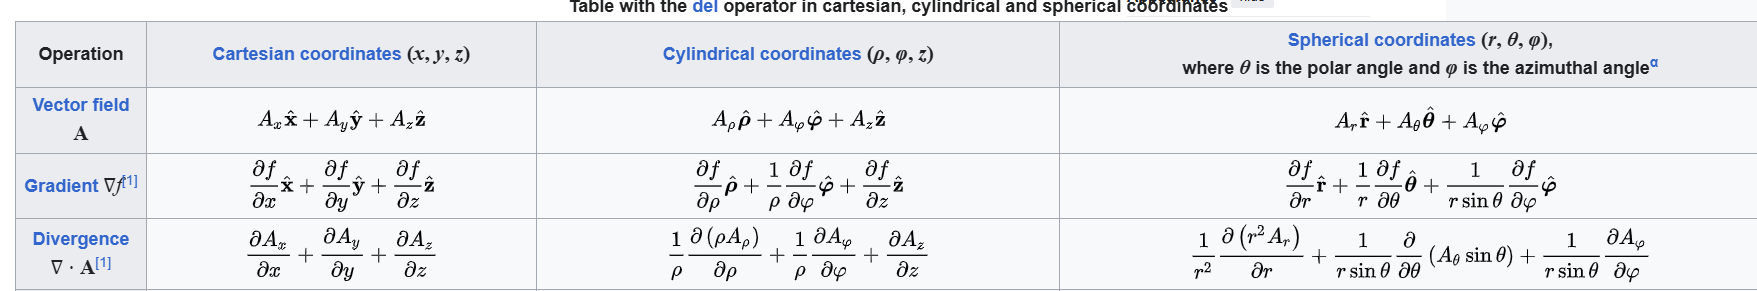

In [8]:
        # call model, set optimizer. Feeding my flattened, torch theta and phi
        model = CoreFlowPINN()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

        loss_history = []

        # Training loop
        for epoch in range(100):
            optimizer.zero_grad()

            # Predict u_theta and u_phi using the PINN
            u_pred = model(inputs)
            u_theta = u_pred[:, 0:1]  #[:, 0:1] here the first part is for row and second is column. so 0:1 means 1st col and all rows
            # for each row, 1st column is theta and 2nd is phi
            u_phi   = u_pred[:, 1:2]






            #loss function preparation

            #L1

            r = torch.tensor(3480e3, dtype=torch.float32)

            # to calculate divergence according to image of formula above
            q_theta = u_theta * Br  # A theta
            q_phi   = u_phi * Br    # A phi

            q_theta_sin = q_theta * torch.sin(theta)  # A theta times sin theta (like the formula)

            # differentiation of the both terms seen in formula
            dq_theta_sin_dtheta = torch.autograd.grad(
                q_theta_sin, theta,
                grad_outputs=torch.ones_like(q_theta_sin),
                create_graph=True, retain_graph=True
            )[0]

            # q_phi is differentiated, no need for sine as it is not in formula
            dq_phi_dphi = torch.autograd.grad(
                q_phi, phi,
                grad_outputs=torch.ones_like(q_phi),
                create_graph=True, retain_graph=True
            )[0]

            divergence_L1 = (1 / (r * torch.sin(theta))) * (
                dq_theta_sin_dtheta + dq_phi_dphi
            )

            residual = dBr_dt + divergence_L1
            loss_L1 = torch.mean(residual ** 2)




            # L2
            # according to formula the definitions are just different
            #find divergence
            cos2_theta = torch.cos(theta) ** 2

            q2_theta = u_theta * cos2_theta
            q2_phi   = u_phi * cos2_theta

            # same as L1
            q2_theta_sin = q2_theta * torch.sin(theta)

            dq2_theta_sin_dtheta = torch.autograd.grad(
                q2_theta_sin, theta,
                grad_outputs=torch.ones_like(q2_theta_sin),
                create_graph=True, retain_graph=True
            )[0]

            dq2_phi_dphi = torch.autograd.grad(
                q2_phi, phi,
                grad_outputs=torch.ones_like(q2_phi),
                create_graph=True, retain_graph=True
            )[0]

            divergence_L2 = (1 / (r * torch.sin(theta))) * (
                dq2_theta_sin_dtheta + dq2_phi_dphi
            )

            # no residual like L1 since there’s nothing to compare to
            loss_L2 = torch.mean(divergence_L2 ** 2)

            # Total loss: L1² + L2²
            loss = loss_L1 + loss_L2




            #backpropagation and adjusting weights

            loss.backward()
            optimizer.step()



            print(f"{year} : Epoch {epoch} --- Loss {loss.item():.6f}")


2020 : Epoch 0 --- Loss 14942578.000000
2020 : Epoch 1 --- Loss 14942572.000000
2020 : Epoch 2 --- Loss 14942566.000000
2020 : Epoch 3 --- Loss 14942561.000000
2020 : Epoch 4 --- Loss 14942556.000000


/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: grad and param do not obey the gradient layout contract. This is not an error, but may impair performance.
grad.sizes() = [7200, 1], strides() = [1, 0]
param.sizes() = [7200, 1], strides() = [1, 0] (Triggered internally at /pytorch/torch/csrc/autograd/functions/accumulate_grad.h:218.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


2020 : Epoch 5 --- Loss 14942550.000000
2020 : Epoch 6 --- Loss 14942547.000000
2020 : Epoch 7 --- Loss 14942540.000000
2020 : Epoch 8 --- Loss 14942536.000000
2020 : Epoch 9 --- Loss 14942530.000000
2020 : Epoch 10 --- Loss 14942527.000000
2020 : Epoch 11 --- Loss 14942521.000000
2020 : Epoch 12 --- Loss 14942516.000000
2020 : Epoch 13 --- Loss 14942512.000000
2020 : Epoch 14 --- Loss 14942506.000000
2020 : Epoch 15 --- Loss 14942502.000000
2020 : Epoch 16 --- Loss 14942497.000000
2020 : Epoch 17 --- Loss 14942494.000000
2020 : Epoch 18 --- Loss 14942489.000000
2020 : Epoch 19 --- Loss 14942484.000000
2020 : Epoch 20 --- Loss 14942479.000000
2020 : Epoch 21 --- Loss 14942474.000000
2020 : Epoch 22 --- Loss 14942472.000000
2020 : Epoch 23 --- Loss 14942465.000000
2020 : Epoch 24 --- Loss 14942462.000000
2020 : Epoch 25 --- Loss 14942457.000000
2020 : Epoch 26 --- Loss 14942454.000000
2020 : Epoch 27 --- Loss 14942448.000000
2020 : Epoch 28 --- Loss 14942446.000000
2020 : Epoch 29 --- L

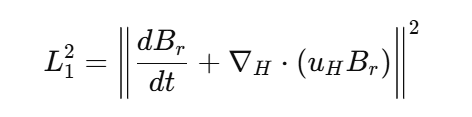

In [17]:
            '''


            q_theta = u_theta * Br #A theta
            q_phi   = u_phi * Br   # A phi

            q_theta_sin = q_theta * torch.sin(theta)

            dq_theta_sin_dtheta = torch.autograd.grad(
                q_theta_sin, theta,
                grad_outputs=torch.ones_like(q_theta_sin),
                create_graph=True, retain_graph=True
            )[0]

            dq_phi_dphi = torch.autograd.grad(
                q_phi, phi,
                grad_outputs=torch.ones_like(q_phi),
                create_graph=True, retain_graph=True
            )[0]

            divergence = (1 / (r * torch.sin(theta))) * (
                dq_theta_sin_dtheta + dq_phi_dphi
            )

            # testing
            residual = dBr_dt + divergence
            loss_L1 = torch.mean(residual ** 2)

            '''

'\n\n\nq_theta = u_theta * Br #A theta\nq_phi   = u_phi * Br   # A phi\n\nq_theta_sin = q_theta * torch.sin(theta)\n\ndq_theta_sin_dtheta = torch.autograd.grad(\n    q_theta_sin, theta,\n    grad_outputs=torch.ones_like(q_theta_sin),\n    create_graph=True, retain_graph=True\n)[0]\n\ndq_phi_dphi = torch.autograd.grad(\n    q_phi, phi,\n    grad_outputs=torch.ones_like(q_phi),\n    create_graph=True, retain_graph=True\n)[0]\n\ndivergence = (1 / (r * torch.sin(theta))) * (\n    dq_theta_sin_dtheta + dq_phi_dphi\n)\n\n# testing\nresidual = dBr_dt + divergence\nloss_L1 = torch.mean(residual ** 2)\n\n'

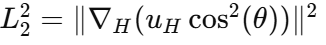

In [18]:
'''
# === L2²: quasi-geostrophic constraint ===
            cos2_theta = torch.cos(theta) ** 2
            q2_theta = u_theta * cos2_theta
            q2_phi   = u_phi * cos2_theta
            q2_theta_sin = q2_theta * torch.sin(theta)

            dq2_theta_sin_dtheta = torch.autograd.grad(
                q2_theta_sin, theta,
                grad_outputs=torch.ones_like(q2_theta_sin),
                create_graph=True, retain_graph=True
            )[0]

            dq2_phi_dphi = torch.autograd.grad(
                q2_phi, phi,
                grad_outputs=torch.ones_like(q2_phi),
                create_graph=True, retain_graph=True
            )[0]

            divergence_qg = (1 / (r * torch.sin(theta))) * (
                dq2_theta_sin_dtheta + dq2_phi_dphi
            )

            loss_L2 = torch.mean(divergence_qg ** 2)
            '''

'\n# === L2²: quasi-geostrophic constraint ===\n            cos2_theta = torch.cos(theta) ** 2\n            q2_theta = u_theta * cos2_theta\n            q2_phi   = u_phi * cos2_theta\n            q2_theta_sin = q2_theta * torch.sin(theta)\n\n            dq2_theta_sin_dtheta = torch.autograd.grad(\n                q2_theta_sin, theta,\n                grad_outputs=torch.ones_like(q2_theta_sin),\n                create_graph=True, retain_graph=True\n            )[0]\n\n            dq2_phi_dphi = torch.autograd.grad(\n                q2_phi, phi,\n                grad_outputs=torch.ones_like(q2_phi),\n                create_graph=True, retain_graph=True\n            )[0]\n\n            divergence_qg = (1 / (r * torch.sin(theta))) * (\n                dq2_theta_sin_dtheta + dq2_phi_dphi\n            )\n\n            loss_L2 = torch.mean(divergence_qg ** 2)\n            '

In [19]:
import matplotlib.pyplot as plt

for year, losses in loss_history_by_year.items():
    plt.plot(losses, label=f"{year}")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curves for the 3 years")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



NameError: name 'loss_history_by_year' is not defined